## Logical Reasoning

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from mlflow.sklearn import save_model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer, AutoTokenizer 

import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    tokenize
)

#### Define a compute metrics for this dataset (I wasn't sure if the one we have is suitable)

In [3]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
    }

### ReClor preperation

In [4]:
import json
import pandas as pd

from datasets import Dataset

In [5]:
# Load the JSON file for training

with open("../data/reclor_data/train.json", "r") as f:
    data = json.load(f)

# Convert JSON to DataFrame
records = []
for item in data:
    record = {
        "context": item["context"],
        "question": item["question"],
        "choice_0": item["answers"][0],
        "choice_1": item["answers"][1],
        "choice_2": item["answers"][2],
        "choice_3": item["answers"][3],
        "label": item["label"]
    }
    records.append(record)

df = pd.DataFrame(records)

# Save to CSV
df.to_csv("../data/reclor_train.csv", index=False)


In [6]:
# Load the JSON file for validation

with open("../data/reclor_data/val.json", "r") as f:
    data = json.load(f)

# Convert JSON to DataFrame
records = []
for item in data:
    record = {
        "context": item["context"],
        "question": item["question"],
        "choice_0": item["answers"][0],
        "choice_1": item["answers"][1],
        "choice_2": item["answers"][2],
        "choice_3": item["answers"][3],
        "label": item["label"]
    }
    records.append(record)

df = pd.DataFrame(records)

# Save to CSV
df.to_csv("../data/reclor_val.csv", index=False)

In [7]:
pd.set_option('display.max_colwidth', None)
df_train = pd.read_csv("../data/reclor_train.csv")
df_train = df_train.sample(n=500, random_state=42).reset_index(drop=True)


# Ensure number of rows is divisible by 4
remainder = len(df_train) % 4
if remainder != 0:
    df_train = df_train.iloc[:-remainder]
df_train.head()

,context,question,choice_0,choice_1,choice_2,choice_3,label
0,"Researchers have found that when very overweight people, who tend to have relatively low metabolic rates, lose weight primarily through dieting, their metabolisms generally remain unchanged. They will thus burn significantly fewer calories at the new weight than do people whose weight is normally at that level. Such newly thin persons will, ttherefore, ultimately regain weight until their body size again matches their metabolic rate.",The conclusion of the argument above depends on which of the following assumptions?,The amount of calories that a person usually burns in a day is determined more by the amount that is consumed that day than by the current weight of the individual.,The metabolisms of people who are usually not overweight are much more able to vary than the metabolisms of people who have been very overweight.,Researchers have not yet determined whether the metabolic rates of formerly very overweight individuals can be accelerated by means of chemical agents.,Relatively few very overweight people who have dieted down to a new weight tend to continue to consume substantially fewer calories than do people whose normal weight is at that level.,3
1,"Decision makers tend to have distinctive styles. One such style is for the decision maker to seek the widest possible input from advisers and to explore alternatives while making up his or her mind. In fact, decision makers of this sort will often argue vigorously for a particular idea, emphasizing its strong points and downplaying its weaknesses, not because they actually believe in the idea but because they want to see if their real reservations about it are idiosyncratic or are held independently by their advisers.",Which one of the following is most strongly supported by the statements above?,"If certain decision makers' statements are quoted accurately and at length, the content of the quote could nonetheless be greatly at variance with the decision eventually made.",Certain decision makers do not know which ideas they do not really believe in until after they have presented a variety of ideas to their advisers.,"If certain decision makers' advisers know the actual beliefs of those they advise, those advisers will give better advice than they would if they did not know those beliefs.",Certain decision makers proceed in a way that makes it likely that they will frequently decide in favor of ideas in which they do not believe.,0
2,"Political strategist: Clearly, attacking an opposing candidate on philosophical grounds is generally more effective than attacking the details of the opponent' s policy proposals. A philosophical attack links an opponent' s policy proposals to an overarching ideological scheme, thereby telling a story and providing context. This makes the attack emotionally compelling.",Which one of the following is an assumption required by the political strategist' s argument?,The stories that people are most likely to remember are those that are emotionally compelling.,Political attacks that tell a story are able to provide more context than those that do not.,Voters are typically uninterested in the details of candidates' policy proposals.,Political attacks that are emotionally compelling are generally more effective than those that are not.,3
3,"Jones is selling a house to Smith. The contract between the two specifies that for up to a year after ownership is transferred, Jones will be responsible for repairing any ""major structural defects, "" defined as defects in the roof or roof-supporting components of the house, that might be found. Jones is not responsible for any other repairs. The house has a truss roof, which means that the only walls that support the roof are the exterior walls.",It can be properly concluded from the information above that,the contract does not oblige Jones to repair any defects in the house's nonexterior walls after ownership of the house has been transferred,Jones

In [8]:
pd.set_option('display.max_colwidth', None)
df_val = pd.read_csv("../data/reclor_val.csv")
df_val = df_val.sample(n=500, random_state=42).reset_index(drop=True)

# Ensure number of rows is divisible by 4
remainder = len(df_val) % 4
if remainder != 0:
    df_val = df_val.iloc[:-remainder]
df_val.shape

(500, 7)

In [9]:
# Create prompt pairs: question + each choice with context. It prepares a list of 4 options per question, 
# to be used as a batch of 4 input choices during fine-tuning in a multiple-choice setting.

def flatten_choices(example):
    context = example["context"]
    question = example["question"]
    return {
        "choices": [
            f"{question} {choice}" for choice in [example["choice_0"], example["choice_1"], example["choice_2"], example["choice_3"]]
        ],
        "context": [context] * 4,
        "label": example["label"]
    }

In [10]:
# Turn each row into 4 entries, each combining context + one of the 4 choices
processed_train = df_train.apply(flatten_choices, axis=1, result_type="expand")
processed_val = df_val.apply(flatten_choices, axis=1, result_type="expand")

In [11]:
# Expand to lists
choices_flat = sum(processed_train["choices"].tolist(), [])
context_flat = sum(processed_train["context"].tolist(), [])
labels = processed_train["label"].tolist()

choices_flat_val = sum(processed_val["choices"].tolist(), [])
context_flat_val = sum(processed_val["context"].tolist(), [])
labels_val = processed_val["label"].tolist()

In [12]:
# Combine context and choice into full text
paired_texts = [f"{c} {q}" for c, q in zip(context_flat, choices_flat)]
paired_texts_val = [f"{c} {q}" for c, q in zip(context_flat_val, choices_flat_val)]

In [13]:
# Tokenize paired text
encodings = tokenize(paired_texts, "distilbert-base-uncased")
encodings_val = tokenize(paired_texts_val, "distilbert-base-uncased")

In [14]:
# Truncate so total is divisible by 4 (to form batches of 4 choices)  --> This is the added section
n_train = (len(encodings["input_ids"]) // 4) * 4
n_val = (len(encodings_val["input_ids"]) // 4) * 4

for key in encodings:
    encodings[key] = encodings[key][:n_train]
labels = labels[:n_train // 4]

for key in encodings_val:
    encodings_val[key] = encodings_val[key][:n_val]
labels_val = labels_val[:n_val // 4]

In [15]:
# Group into 4-choice batches
# unique ID from the model's vocabulary. 
# This assumes that every group of 4 encodes one example with 4 answer options. So if the total count isn’t divisible by 4, indexing and batching will break.
input_ids = encodings["input_ids"].view(-1, 4, encodings["input_ids"].shape[-1])
attention_mask = encodings["attention_mask"].view(-1, 4, encodings["attention_mask"].shape[-1])

# Dataset ready to go
reclor_dataset_train = {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "labels": labels
}

# Group into 4-choice batches
input_ids_val = encodings_val["input_ids"].view(-1, 4, encodings_val["input_ids"].shape[-1]) # unique ID from the model's vocabulary:
attention_mask_val = encodings_val["attention_mask"].view(-1, 4, encodings_val["attention_mask"].shape[-1])

# Dataset ready to go
reclor_dataset_val = {
    "input_ids": input_ids_val,
    "attention_mask": attention_mask_val,
    "labels": labels
}

### Wrap reclor_dataset into a PyTorch Dataset

In [16]:
from torch.utils.data import Dataset

class ReClorDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["labels"])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

# initialize
train_dataset = ReClorDataset(reclor_dataset_train) 
eval_dataset = ReClorDataset(reclor_dataset_val) 



### Setup

In [17]:
model = AutoModelForMultipleChoice.from_pretrained("distilbert-base-uncased")

Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset= eval_dataset,
    compute_metrics= compute_metrics 
)

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
learning_rate= 3e-5
weight_decay= 0.01
num_train_epochs= 3
evaluation_strategy= 'epoch'
class_weight=True
# dropout= 0.3


params = {
      "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "num_train_epochs": num_train_epochs,
      "evaluation_strategy": evaluation_strategy,
      "class_weight":class_weight,
      # "dropout": dropout,
      "dataset": "ReClor"
  }


# setting the MLFlow connection and experiment
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME
MODEL_NAME = "distilbert-base-uncased"
SAVE_PATH = "../models/distilber-reclor/pytorch_model"

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO)

mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "Training distilbert on logical reasoning ")
mlflow.log_params(params)

Active run_id: c006f29fd8994350bce262606e551e3c


In [20]:
logger.info('training is running')
trainer.train()


INFO:root:training is running


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.391400,1.385858,0.240000,0.237814,0.237556,0.238361
2,1.198700,1.455327,0.226000,0.224277,0.224648,0.224114
3,0.792200,1.586246,0.236000,0.234654,0.234973,0.234552


TrainOutput(global_step=375, training_loss=1.2311290486653645, metrics={'train_runtime': 563.0145, 'train_samples_per_second': 2.664, 'train_steps_per_second': 0.666, 'total_flos': 794790217728000.0, 'train_loss': 1.2311290486653645, 'epoch': 3.0})

## Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.20      0.19       105
           1       0.25      0.25      0.25       134
           2       0.23      0.23      0.23       136
           3       0.27      0.26      0.27       125

    accuracy                           0.24       500
   macro avg       0.23      0.23      0.23       500
weighted avg       0.24      0.24      0.24       500



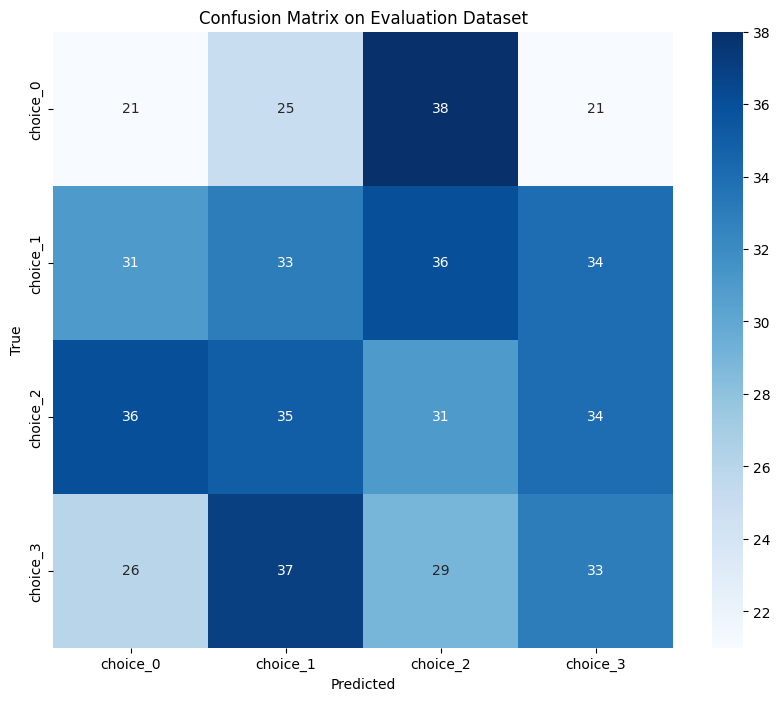

In [21]:
# Run predictions
preds = trainer.predict(eval_dataset)

# Extract true and predicted labels
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)


# Plot confusion matrix
plt.figure(figsize=(10, 8))
labels = ['choice_0', 'choice_1', 'choice_2', 'choice_3']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)  
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Evaluation Dataset")
plt.show()


In [22]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

In [23]:
mlflow.end_run()

🏃 View run Training distilbert on logical reasoning  at: http://127.0.0.1:5001/#/experiments/823412171152425451/runs/c006f29fd8994350bce262606e551e3c
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/823412171152425451


In [26]:
# #save with pytorch
mlflow.pytorch.save_model(model, path=SAVE_PATH)

In [25]:
# # or just save the model? 
# model.save_pretrained("models/reclor-finetuned")
# tokenizer.save_pretrained("models/reclor-finetuned")